In [1]:
import os
import tensorflow as tf

2022-10-08 12:59:47.779120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:

data_directory = os.getcwd().rsplit("/", 1)[0] + "/data/224x224_currency"
print(data_directory)


/Users/ujjwal/Documents/data/224x224_currency


In [43]:
model_dir = os.getcwd() + "/experiments/smaller_model/4_ConvBlock"
data_dir = os.getcwd().rsplit("/", 1)[0] + "/data/224x224_currency"

In [44]:
from model.utils import Params

In [45]:
tf.random.set_seed(230)
json_path = "model/params.json"
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params

In [46]:
train_data_dir = os.path.join(data_dir, "train_dir")
dev_data_dir = os.path.join(data_dir, "dev_dir")

In [47]:
train_filenames = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith(".jpg")]
eval_filenames = [os.path.join(dev_data_dir, f) for f in os.listdir(dev_data_dir) if f.endswith(".jpg")]

    # Labels will be between 0 and 5 included (6 classes in total)
train_labels = [int(f.split("/")[-1].split("_")[0]) for f in train_filenames]
eval_labels = [int(f.split("/")[-1].split("_")[0]) for f in eval_filenames]

In [48]:
len(eval_filenames)

1045

In [49]:
from model.input_fn import input_fn
from sklearn.preprocessing import LabelEncoder

In [50]:
labelencoder = LabelEncoder()
train_labels = labelencoder.fit_transform(train_labels)
eval_labels = labelencoder.fit_transform(eval_labels)

In [51]:
params.train_size = len(train_filenames)
params.eval_size = len(eval_filenames)

train_labels = tf.cast(train_labels, tf.int32)
eval_labels = tf.cast(eval_labels, tf.int32)

In [52]:
train_inputs = input_fn(True, train_filenames, train_labels, params)
eval_inputs = input_fn(False, eval_filenames, eval_labels, params)

In [53]:
train_inputs

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Visualizing data

In [54]:
import matplotlib.pyplot as plt

(224, 224, 3)
32


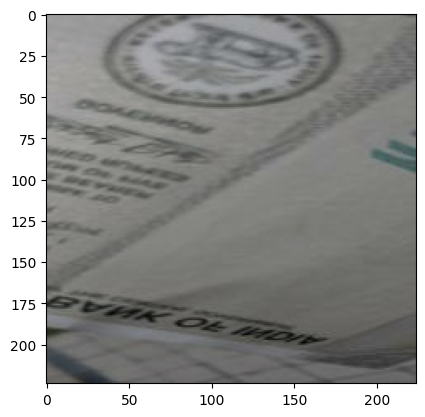

In [55]:
features, labels = next(iter(train_inputs))

print(features[0].shape)
print(len(labels))

plt.imshow(features[0])

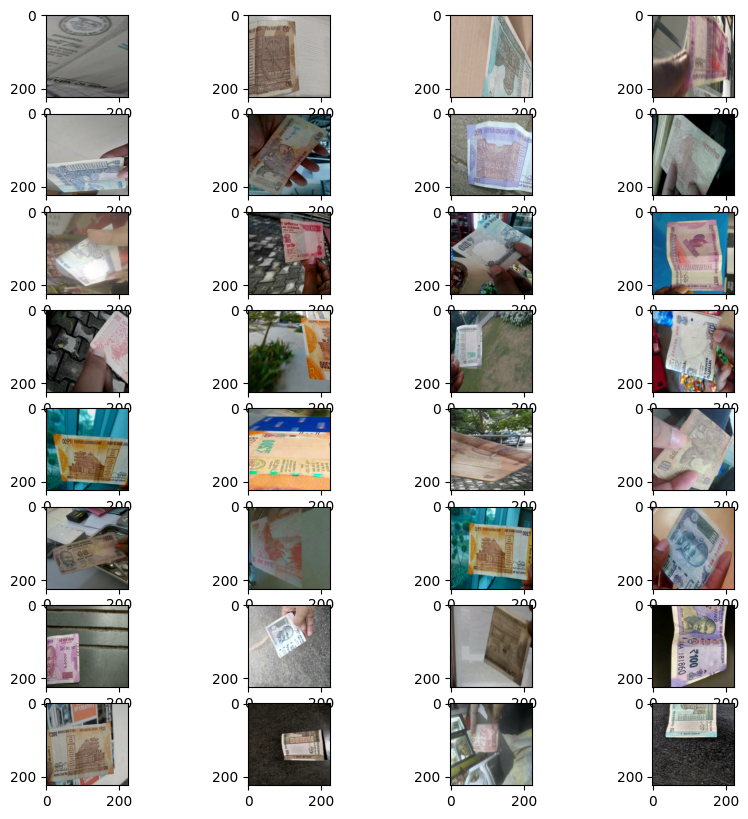

In [56]:
rows=8
cols = 4
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < 32:
            axes[i, j].imshow(features[img_count])
            img_count+=1

In [57]:
from tensorflow.keras import datasets, layers, models

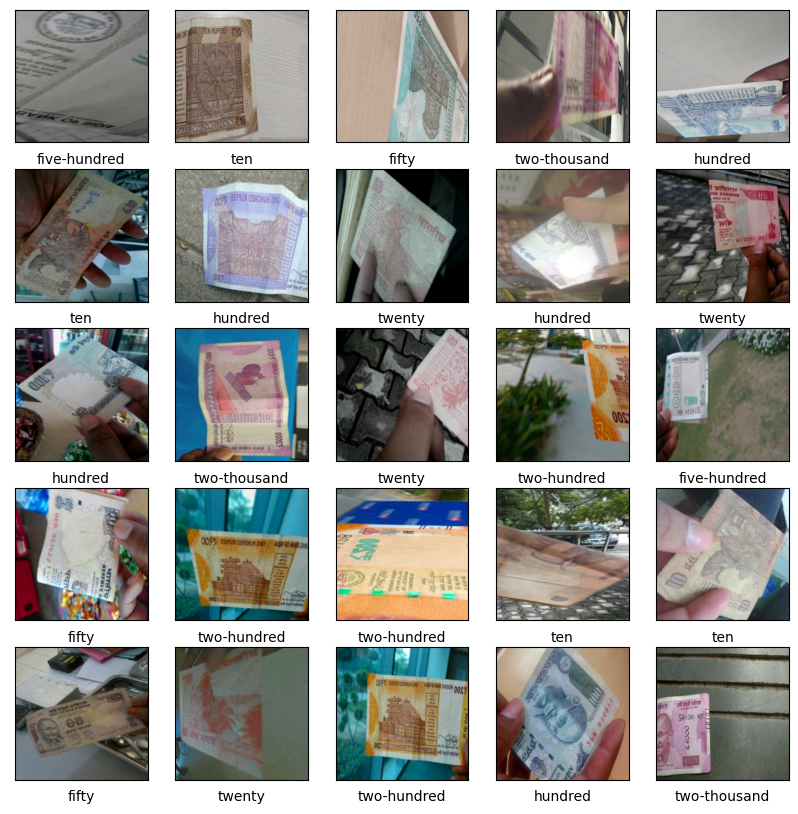

In [58]:
class_names = ['ten', 'twenty', 'fifty', 'hundred', 'two-hundred',
               'five-hundred', 'two-thousand']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i])
    plt.xlabel(class_names[labels[i]])
plt.show()

In [59]:
features, labels = next(iter(train_inputs))

In [60]:
features.shape

TensorShape([32, 224, 224, 3])

In [62]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([4, 5, 6, 3, 0, 1, 0, 6, 1, 0, 5, 2, 2, 4, 4, 4, 3, 6, 3, 4, 2, 3,
       2, 3, 1, 1, 3, 2, 6, 1, 6, 3], dtype=int32)>

# Training on a sequential model

In [67]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7))

In [68]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
for epoch in range(10):
    model.fit(train_inputs)

101/262 [==========>...................] - ETA: 8:11 - loss: 1.6882 - accuracy: 0.3376

KeyboardInterrupt: 

In [75]:
import numpy as np
normalized_ds = train_inputs
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.051715955 0.7177606


In [76]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [82]:
batch_size = 32
img_height = 224
img_width = 224

In [83]:
class_names = [0,1,2,3,4,5,6]
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [95]:
img = data_augmentation(features[0])
plt.imshow(img)


ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)

In [103]:
img = features[0][None,:]
img.shape

TensorShape([1, 224, 224, 3])

In [ ]:
data_augmentation(img)